In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
holidays = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv',parse_dates =['date'])
oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv',parse_dates =['date'])
sample_submission = pd.read_csv('../input/store-sales-time-series-forecasting/sample_submission.csv')
stores = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv')
test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv',parse_dates =['date'])
train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv',parse_dates =['date'])
transactions = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv',parse_dates =['date'])

1. Structure Investigation
2. Quality Investigation
3. Content Investigation

Structure Investigation

In [3]:
train.shape

(3000888, 6)

In [4]:
pd.value_counts(train.dtypes)

int64             3
datetime64[ns]    1
object            1
float64           1
dtype: int64

In [5]:
# Display non-numerical features
train.select_dtypes(exclude="number").head()

,date,family
0,2013-01-01,AUTOMOTIVE
1,2013-01-01,BABY CARE
2,2013-01-01,BEAUTY
3,2013-01-01,BEVERAGES
4,2013-01-01,BOOKS


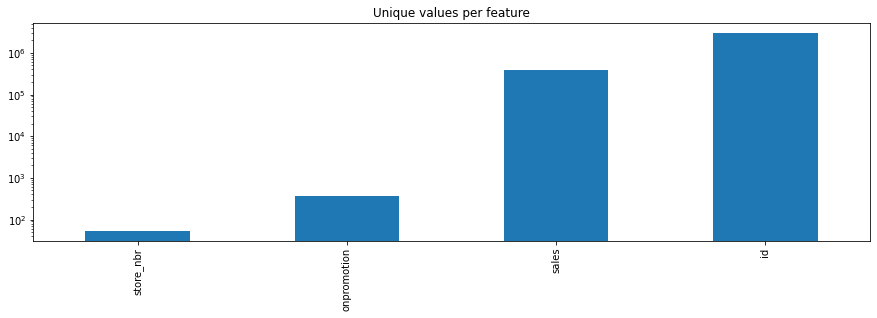

In [6]:
# For each numerical feature compute number of unique entries
unique_values = train.select_dtypes(include="number").nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature");

Quality Investigation

*2.1. Duplicates*

In [7]:
# Check number of duplicates while ignoring the index feature
n_duplicates = train.drop(labels=["id"], axis=1).duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in your dataframe.")

You seem to have 0 duplicates in your dataframe.


If we had any duplicates we would have dropped them as follows

In [8]:
#  Extract column names of all features, except 'id'
columns_to_consider = train.drop(labels=["id"], axis=1).columns

# Drop duplicates based on 'columns_to_consider'
train = train.drop_duplicates(subset=columns_to_consider)
train.shape

(3000888, 6)

*2.2. Missing values*

*2.2.1. Per sample*

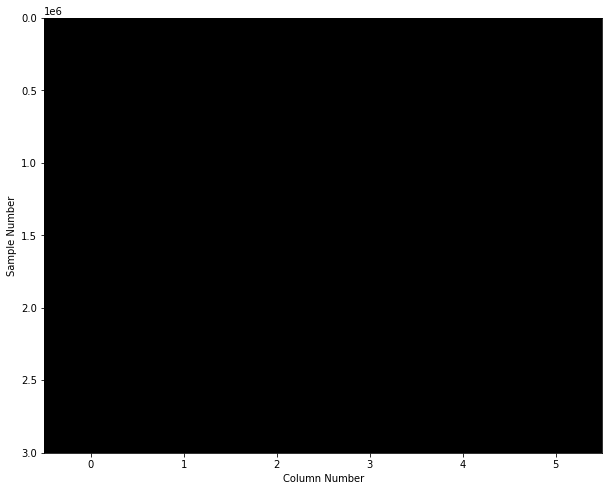

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(train.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number");

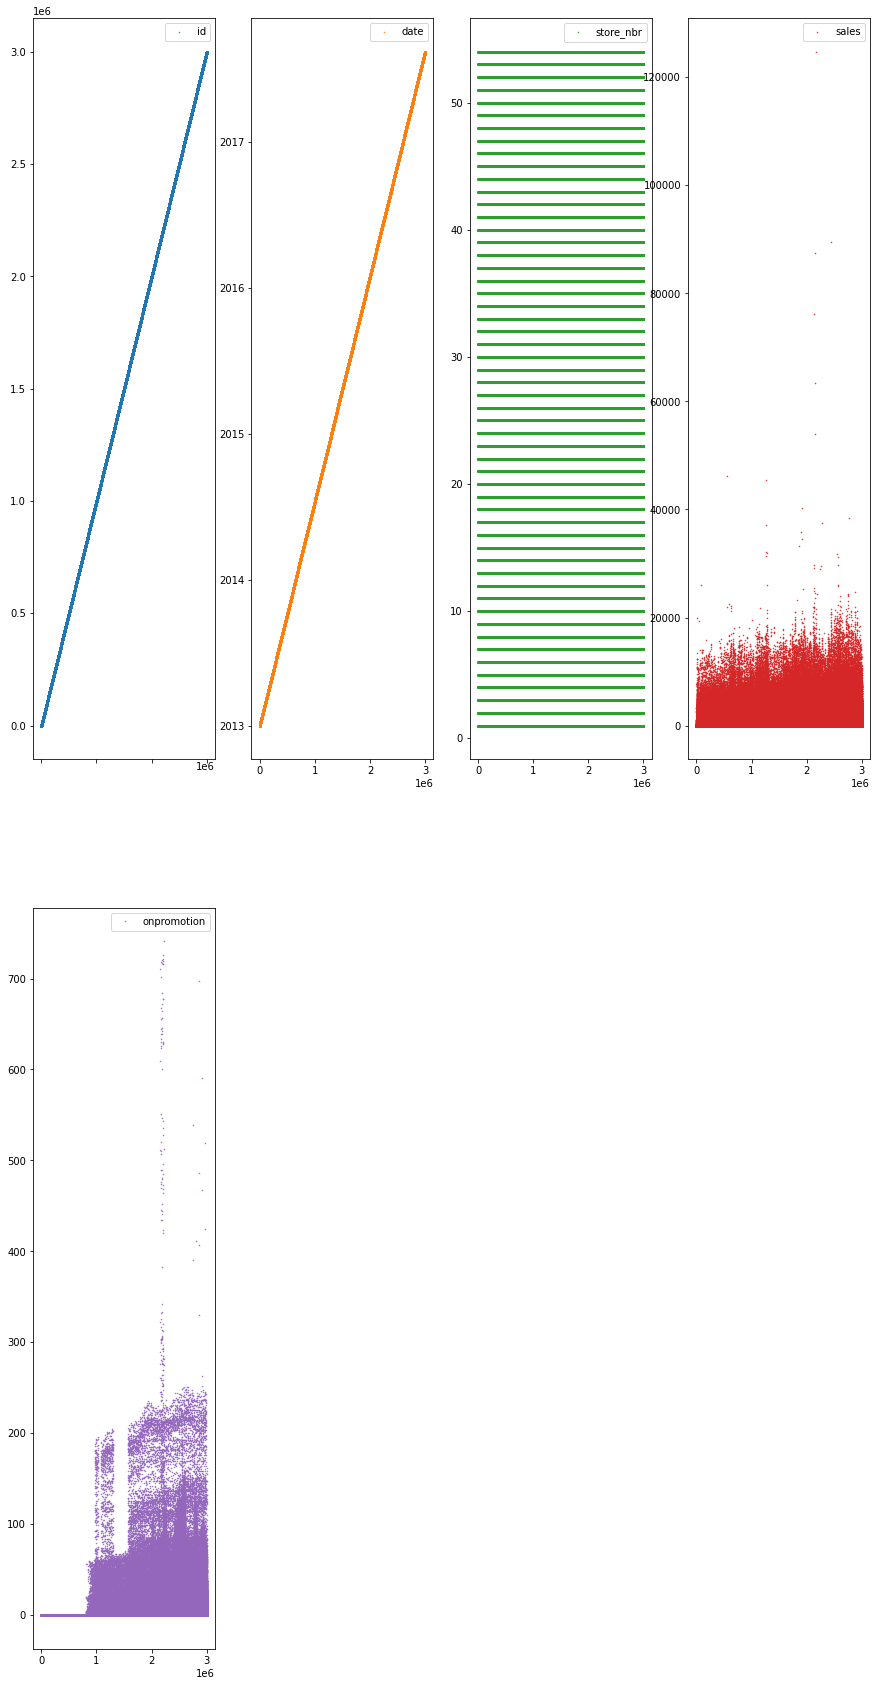

In [10]:
train.plot(lw=0, marker=".", subplots=True, layout=(-1, 4),
          figsize=(15, 30), markersize=1);

*2.3.2. Non-numerical features*

In [11]:
# Extract descriptive properties of non-numerical features
train.describe(exclude=["number", "datetime"])

,family
count,3000888
unique,33
top,AUTOMOTIVE
freq,90936


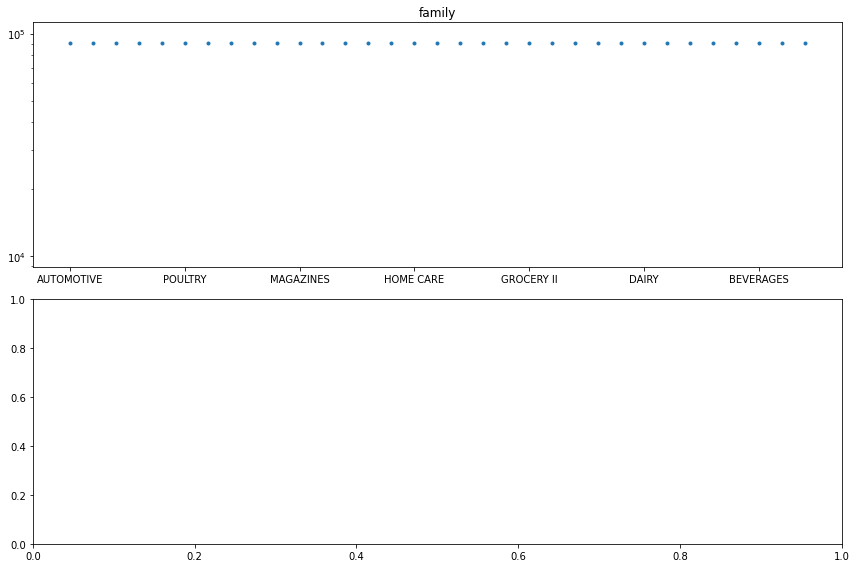

In [12]:
# Create figure object with 3 subplots
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12, 8))

# Identify non-numerical features
df_non_numerical = train.select_dtypes(exclude=["number", "datetime"])

# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df_non_numerical.columns, axes.ravel()):

    # Selects one single feature and counts number of occurrences per unique value
    df_non_numerical[col].value_counts().plot(

        # Plots this information in a figure with log-scaled y-axis
        logy=True, title=col, lw=0, marker=".", ax=ax)
    
plt.tight_layout();

*3. Content Investigation*

*3.1. Feature distribution*

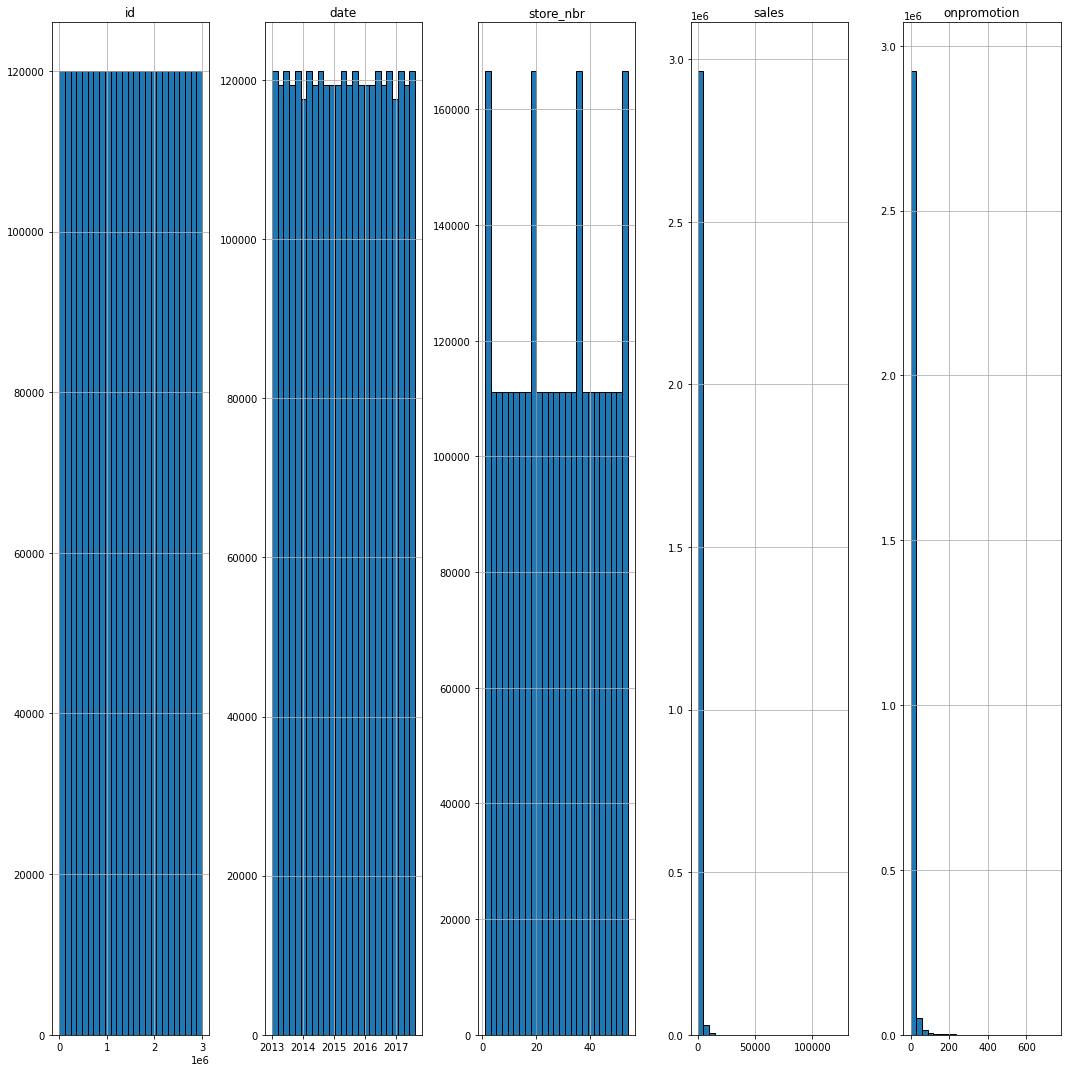

In [13]:
# Plots the histogram for each numerical feature in a separate subplot
train.hist(bins=25, figsize=(15, 15), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

id           1.000000e+00
family       1.099674e-05
date         3.332347e-07
store_nbr    3.332347e-07
sales        3.332347e-07
dtype: float64

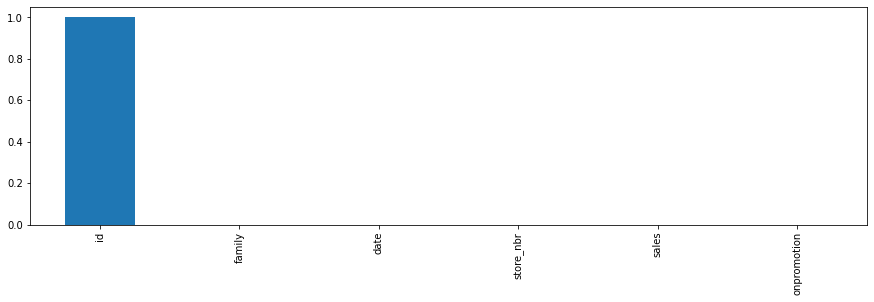

In [14]:
# Collects for each feature the most frequent entry
most_frequent_entry = train.mode()

# Checks for each entry if it contains the most frequent entry
df_freq = train.eq(most_frequent_entry.values, axis=1)

# Computes the mean of the 'is_most_frequent' occurrence
df_freq = df_freq.mean().sort_values(ascending=False)

# Show the 5 top features with the highest ratio of singular value content
display(df_freq.head())

# Visualize the 'df_freq' table
df_freq.plot.bar(figsize=(15, 4));

3.2. Feature patterns

In [15]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

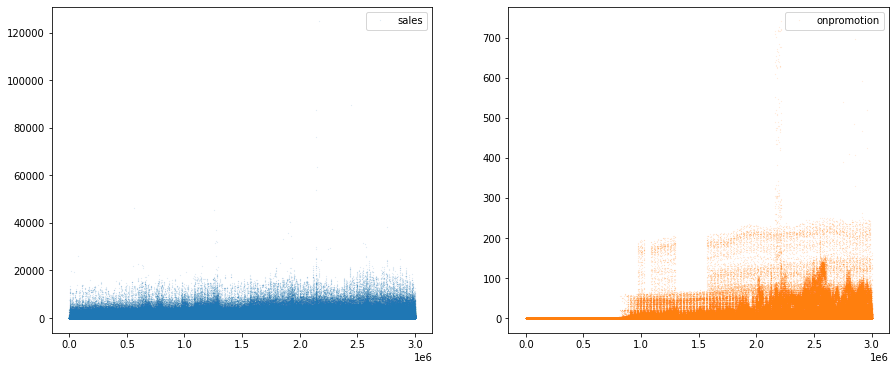

In [16]:
train[["family", "sales",
      "onpromotion"]].plot(
    lw=0, marker=".", subplots=True, layout=(-1, 2), markersize=0.1, figsize=(15, 6));

In [17]:
# Creates mask to identify numerical features with more or less than 25 unique features
cols_continuous = train.select_dtypes(include="number").nunique() >= 25

In [18]:
# Create a new dataframe which only contains the continuous features
df_continuous = train[cols_continuous[cols_continuous].index]
df_continuous.shape

(3000888, 4)

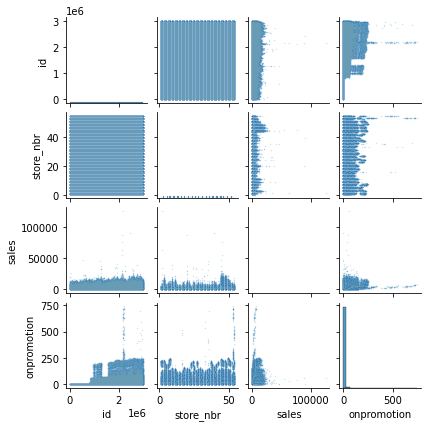

In [19]:
import seaborn as sns

sns.pairplot(df_continuous, height=1.5, plot_kws={"s": 2, "alpha": 0.2});

In [20]:
merged = pd.merge(train, oil, how = 'left', on='date')
merged = pd.merge(merged, holidays, how = 'left',on = 'date')
merged = pd.merge(merged, transactions, how ='left', on =['date','store_nbr'])
merged = pd.merge(merged, stores, how = 'left', on = 'store_nbr')
merged.rename(columns={'type_x':'holiday_type', 'type_y':'store_type'}, inplace = True)
merged

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,description,transferred,transactions,city,state,store_type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155.0,Quito,Pichincha,B,6
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155.0,Quito,Pichincha,B,6
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155.0,Quito,Pichincha,B,6
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155.0,Quito,Pichincha,B,6


In [21]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
for column in merged.columns:
    merged[column] = labelencoder.fit_transform(merged[column])

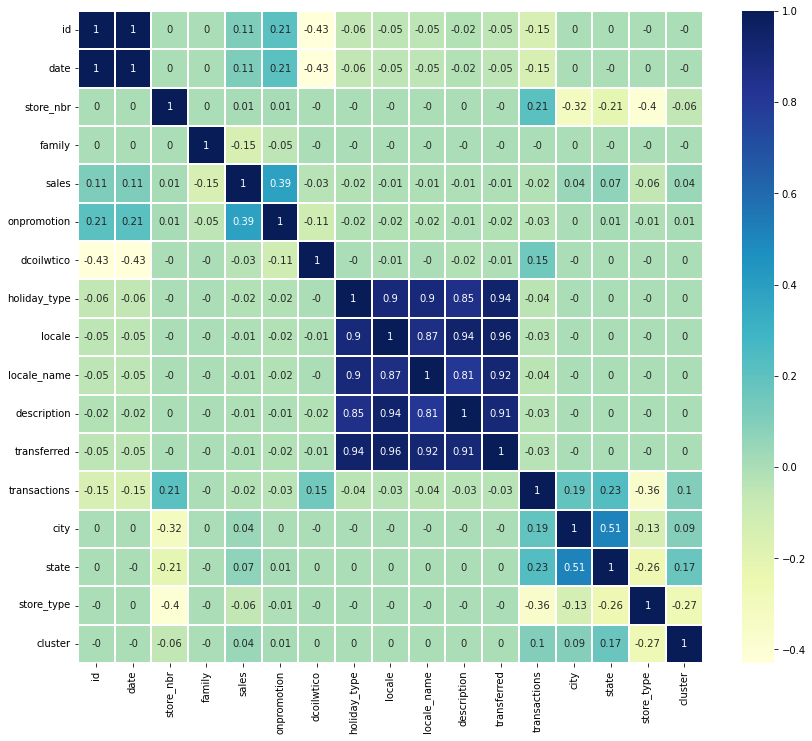

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,12))
matrix = merged.corr().round(2)
sns.heatmap(matrix,linewidths=.1,cmap="YlGnBu",annot=True)
plt.yticks(rotation=0);
plt.show()

Test for Normality- Most tests assume data is Normaly distributed
1. A normal distribution shows that the data that tend to cluster around the mean have more frequent occurrences than other data far from the mean.

2. Bell shaped
3. Symmetrical
4. Unimodal – it has one “peak”
5. Mean and median are equal; both are located at the center of the distribution
6. About 68% of data falls within one standard deviation of the mean
7. About 95% of data falls within two standard deviations of the mean
8. About 99.7% of data falls within three standard deviations of the mean

**How to check for NOrmal Distribution**
* (Visual Method) Create a histogram.
* (Visual Method) Create a Q-Q plot.
* (Formal Statistical Test) Perform a Shapiro-Wilk Test.
* (Formal Statistical Test) Perform a Kolmogorov-Smirnov Test.
* Log Transformation: Transform the values from x to log(x)